In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/pytorch/captum
%cd captum
!git checkout "optim-wip"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

Cloning into 'captum'...
remote: Enumerating objects: 23383, done.
remote: Counting objects: 100% (956/956), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 23383 (delta 436), reused 868 (delta 382), pack-reused 22427
Receiving objects: 100% (23383/23383), 269.55 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (14314/14314), done.
Updating files: 100% (412/412), done.
/content/captum
Branch 'optim-wip' set up to track remote branch 'optim-wip' from 'origin'.
Switched to a new branch 'optim-wip'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/captum
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Running setup.py develop for captum
/content


In [ ]:
from lucent.optvis import render, param, transform, objectives

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from torch import Tensor
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.transforms._presets import ImageClassification
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param
from typing import Any, Callable, List, Optional, Type, Union
from captum.optim.models._common import Conv2dSame, RedirectedReluLayer, SkipLayer

_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

class ResNet18_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet18-f37072fd.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False,
        skip_batchnorm: bool = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)        
        if use_linear_modules_only:
          self.relu = SkipLayer()
        else:
          self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.skip_batchnorm = skip_batchnorm

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        if not self.skip_batchnorm:
          out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False,
        skip_batchnorm: bool = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        
        
        if use_linear_modules_only:
          self.relu = SkipLayer()
        else:
          self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.skip_batchnorm = skip_batchnorm

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        if not self.skip_batchnorm:
          out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        use_linear_modules_only: bool = False,
        skip_batchnorm: bool = False
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        if skip_batchnorm:
          self.skip_batchnorm = True
        else:
          self.skip_batchnorm = False
          
        self.bn1 = norm_layer(self.inplanes)
        if use_linear_modules_only:
          self.use_linear_modules_only = True
          self.relu = SkipLayer()
          self.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        else:
          self.use_linear_modules_only = False
          self.relu = nn.ReLU(inplace=True)
          self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer, self.use_linear_modules_only
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i < blocks-1:
               layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                ))
            else:
                layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                    skip_batchnorm = self.skip_batchnorm
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def build_resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    use_linear_modules_only: bool = False,
    skip_batchnorm = False,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, use_linear_modules_only=use_linear_modules_only, skip_batchnorm = skip_batchnorm, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

In [ ]:
from torchvision.models.resnet import ResNet18_Weights
from lucent.modelzoo import resnet
weights = ResNet18_Weights.verify("IMAGENET1K_V1")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

custom_model = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True, use_linear_modules_only=False, skip_batchnorm = False).to(device).eval()
#linear_model = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True, use_linear_modules_only=True, skip_batchnorm = False).to(device).eval()
#model_skip_batchnorm = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True, use_linear_modules_only=False, skip_batchnorm = True).to(device).eval()
#linear_model_skip_batchnorm = build_resnet(BasicBlock, [2, 2, 2, 2], weights=weights, progress=True, use_linear_modules_only=True, skip_batchnorm = True).to(device).eval()
lucent_model = resnet.resnet18().to(device).eval()

In [ ]:
param_f = lambda: param.image(224)

layer = 'layer4'
n_channels = 5
models = [custom_model, lucent_model]

images = []

for n in range(0,10):
  for model in models:
    obj = objectives.channel(layer, n)
    image = render.render_vis(model, obj, param_f)

    images.append(image[0][0])

100%|██████████| 512/512 [00:07<00:00, 64.82it/s]


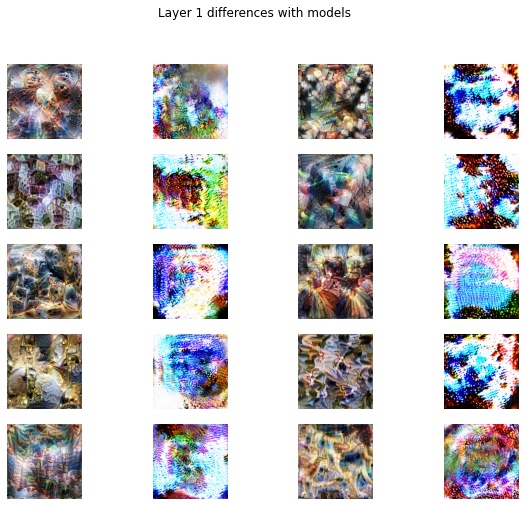

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 1 differences with models')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

In [ ]:
param_f = lambda: param.image(224)

layer = 'layer4'
n_channels = 5
models = [model, linear_model, model_skip_batchnorm, linear_model_skip_batchnorm]

images = []

for n in range(0,5):
  for model in models:
    obj = objectives.channel(layer, n)
    image = render.render_vis(model, obj, param_f)

    images.append(image[0][0])

100%|██████████| 512/512 [00:07<00:00, 72.82it/s]


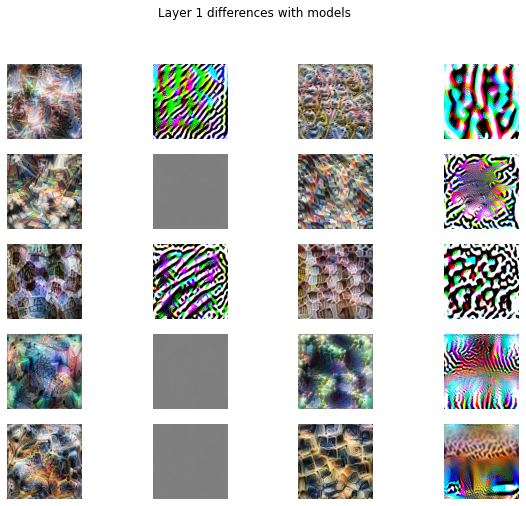

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 1 differences with models')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

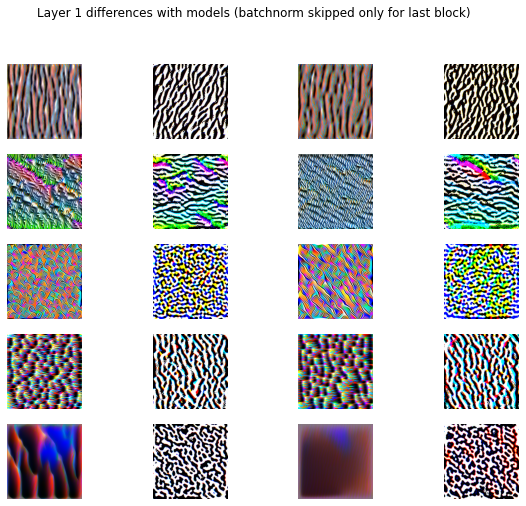

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 1 differences with models (batchnorm skipped only for last block)')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

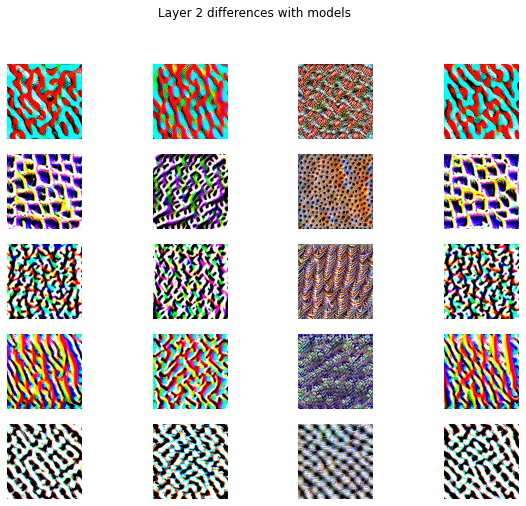

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 2 differences with models')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

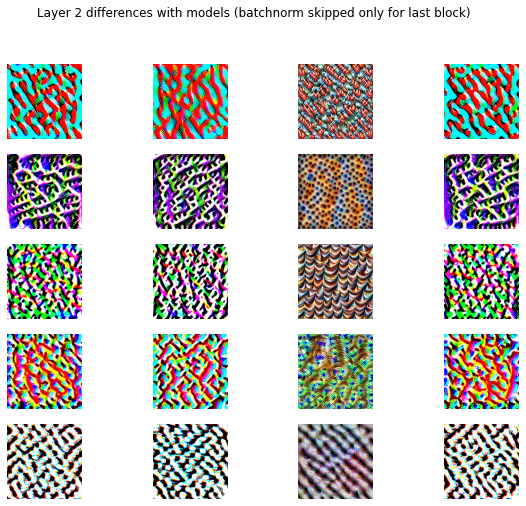

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 2 differences with models (batchnorm skipped only for last block)')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

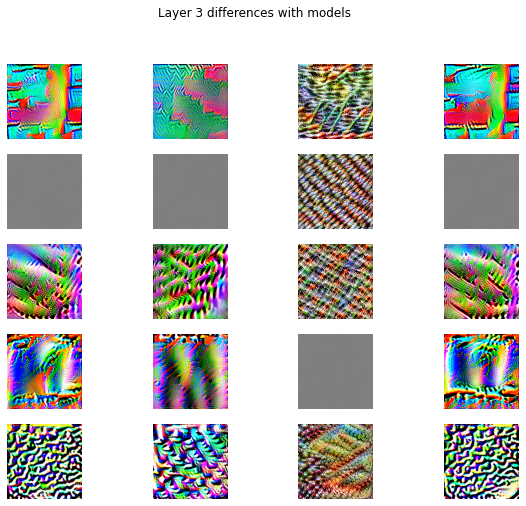

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 3 differences with models')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

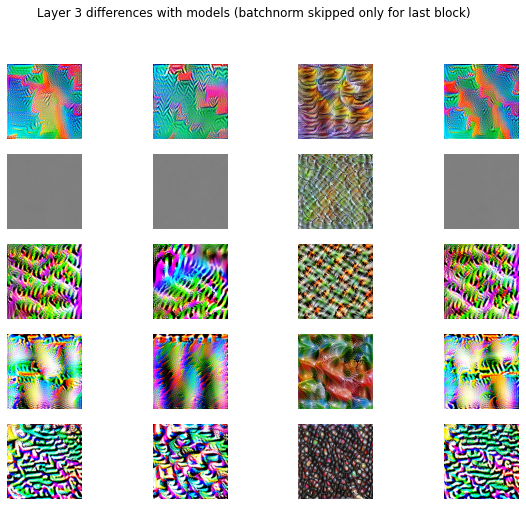

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 3 differences with models (batchnorm skipped only for last block)')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

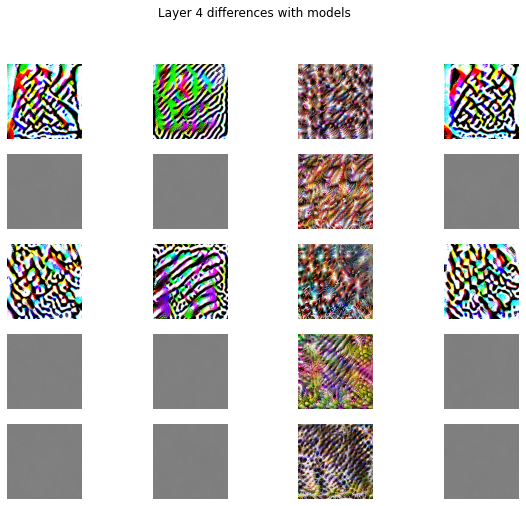

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 4 differences with models')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])

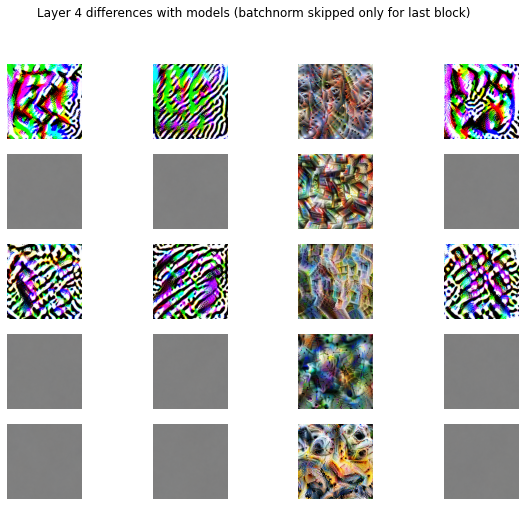

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize = (10, 8))
fig.suptitle('Layer 4 differences with models (batchnorm skipped only for last block)')
for i in range(5):
  for j in range(4):
    ax[i][j].axis('off')
    ax[i][j].imshow(images[4*i + j])